# A-Scan Prediction using Machine Learning

In this notebook, we aim to predict the `A-scan` for a specifc gprMax scenario based on the choice on `parameters` input by the user. For this purpose, we wish to train a Machine Learning model by feeding as inputs -

1) The parameters corresponding to the gprMax scenario
2) The resultant A-scans

We have already generated `6250` output models (`5000` for training & `1250` for testing) for the simplest gprMax scenario - a metal cylinder buried in a a dielectric medium. Each of these models is built using randomly generated parameters, which were saved along with their corresponding output A-scans.

The ML model would be `trained on pairs of input data arrays` (i.e. model parameters, A-scans). We test the performance of popular regression algorithms such as `Random Forest`, `XGBoost`, etc. In addition, we test these methods in conjuction with [Chain Regression](https://scikit-learn.org/stable//modules/generated/sklearn.multioutput.RegressorChain.html). Note that an ML model trained for a specific scenario can only be used to predict A-scans for similar scenarios.

Additionally, to increase the efficiency of the ML algorithm, we compress the A-scans using suitable algorithms (like `PCA` or `TruncatedSVD`) instead of directly feeding them to the ML model. It is observed that the A-scans can effectively be represented using much lesser number of components without any significant loss in signal quality. 

This notebook serves as a template for using the newly added `Random Parameter Generation Feature` in conjuction with Machine Learning. Depending on the scenario being modelled, the user may need to change the hyper-parameters (or use a different ML model) to better fit the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ML_utilities import load_pkl_dat, nmse, plot_pred_dat

## Load & Extract Relevant Data

First, we load the data obtained from the gprMax simulation for our specific case

- `X_data` - The model parameters (generated randomly using gprMax)
- `Y_data` - The corresponing A-scans

In [2]:
path = "/Users/utsavakhaury/gprMax/gprMax/test_models/cylinder/"
X_data = load_pkl_dat(path + "cylinder_rand_{rand_params}_{compressed}.pkl")[0]
Y_data = load_pkl_dat(path + "cylinder_rand_{field_outputs}.pkl")

The dimensions of `X_data` specify the following attributes (in the same order) - 
1. ` No. of models`
2. ` No. of parameters`

In [3]:
print(X_data.shape)

(6250, 4)


The dimensions of `Y_data` specify the following attributes (in the same order)  - 
1. `No. of models`
2. `No. of receivers in each model`
3. `No. of A-scans (Ex, Ey, Ez, Hx, Hy, Hz) corresponding to each receiver`
4. `No. of elements in each A-scan`

In [4]:
print(Y_data.shape)

(6250, 1, 6, 637)


Next, we split the dataset into train-test subset and extract relevant features to apply compression (using `PCA` or `TruncatedSVD`).

- `train_x` - the training dataset of model parameters
- `test_x` - the test dataset of model parameters
- `train_y_full` - the training dataset of all A-scans
- `test_y_full` - the test dataset of all A-scans

Note that there are `six` A-scans `(Ex, Ey, Ez, Hx, Hy, Hz)`. Depending on the orientation of the gprMax model, some of these arrays are `zero` valued. Here, we choose the `Ez` component (index `#2`) for training & testing, which is non-zero.
- `train_y1` - subset of `train_y_full` containing the `Ez` component A-scan
- `test_y` - subset of `test_y_full` containing the `Ez` component A-scan

In [5]:
train_x, test_x, train_y_full, test_y_full = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)
  
train_y1 = train_y_full[:,0,2,:]     # 0th receiver, 2nd A-scan component (i.e. Ez)
test_y = test_y_full[:,0,2,:]        # 0th receiver, 2nd A-scan component (i.e. Ez)

print("Shape - train_x =", train_x.shape)
print("Shape - train_y1 =", train_y1.shape)
print("Shape - test_x =", test_x.shape)
print("Shape - test_y =", test_y.shape)

Shape - train_x = (5000, 4)
Shape - train_y1 = (5000, 637)
Shape - test_x = (1250, 4)
Shape - test_y = (1250, 637)


We now compress the A-scans array using `PCA`. The `apply_compression` function from `ML_utilities.py` can be used for this purpose (check code for usage)

- `train_y` stores the compressed A-scan array
- `n_comp_opt` is the optimal number of elements required to represent the A-scan in compressed form

Notice that the number of components required to represent the same signal has been reduced from `637` to `30`!

In [6]:
from ML_utilities import apply_compression
n_comp_opt, train_y, pca = apply_compression(train_y1, 1e-12, 'PCA')

print("No. of Principle Components =", n_comp_opt)
print("Shape - train_y =", train_y.shape)

No. of Principle Components = 30
Shape - train_y = (5000, 30)


Finally, we compare the `A-scans reconstructed from their compressed representations` with the `orignial A-scans`. We plot only `5` comparison plots out of the entire batch of `5000` training samples.

- `rec_y` stores the A-scan reconstructed from the PCA-compressed version `train_y` (by computing the `inverse PCA transform`)

The NMSE between each reconstructed & orignal A-scan pair is of the order of $10^{-10}$. Also note that most of the signal information is captured by the first ~10 PCA components.

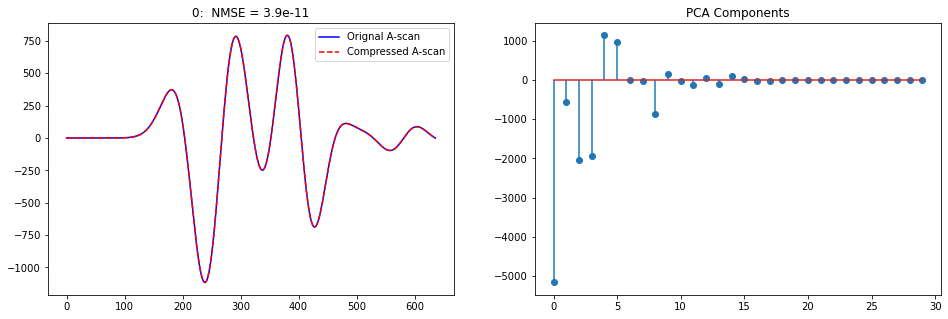

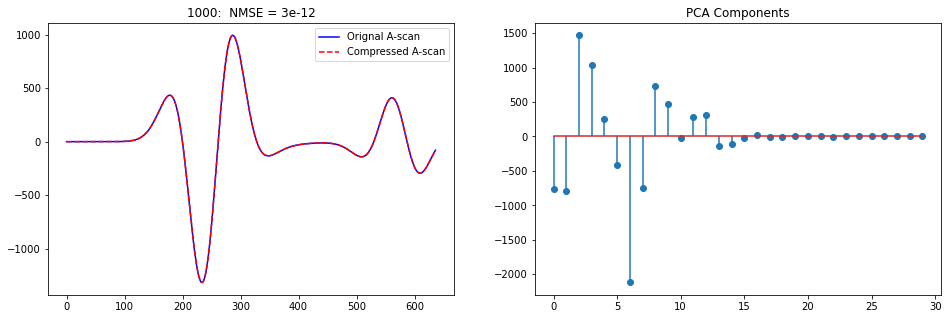

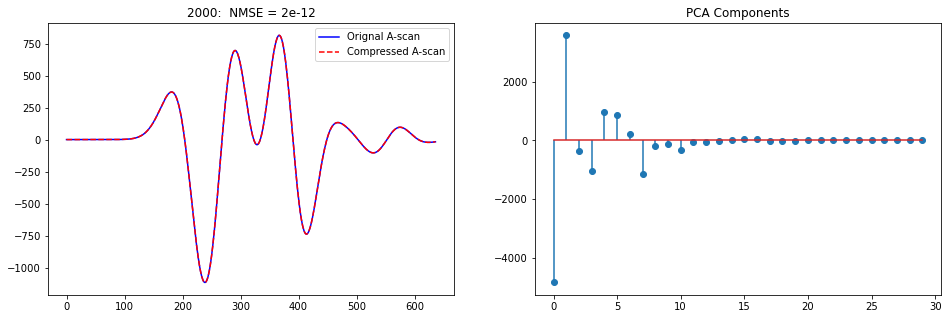

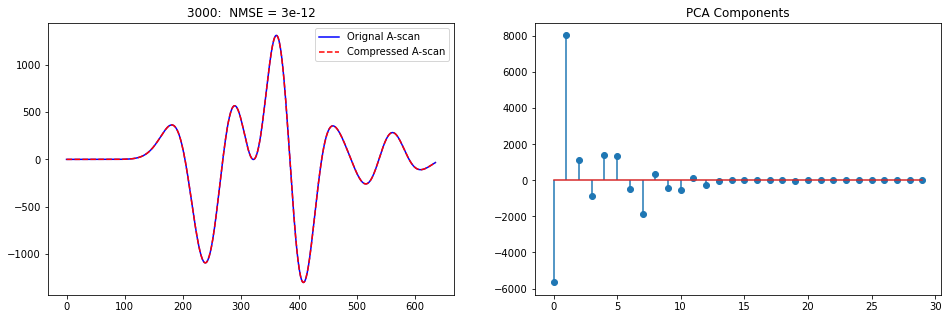

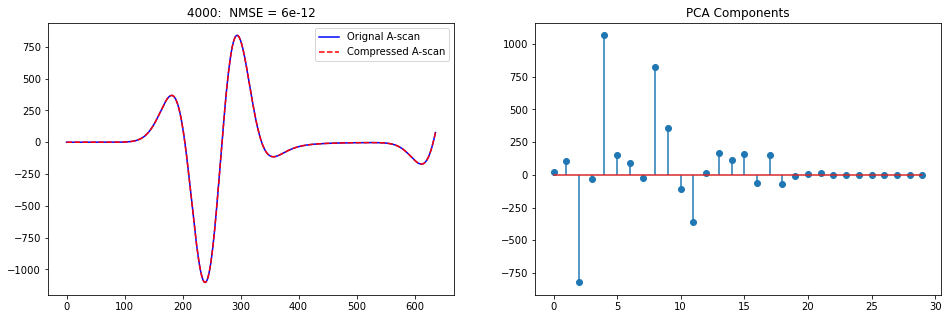

Batch Error = 1.052406254596522e-11


In [7]:
rec_y = pca.inverse_transform(train_y)
batch_err = []

for i in range(0, train_y1.shape[0], 1000):

    A_scan = train_y1[i,:]
    comp_Ascan = train_y[i,:]
    rec_Ascan = rec_y[i,:]

    err = nmse(A_scan, rec_Ascan)
    batch_err.append(err)

    fig = plt.subplots(1,2, figsize=(16,5))
    plt.subplot(121)
    plt.title("{}:  NMSE = {}".format(i, np.around(err, decimals=12)))
    plt.plot(A_scan, '-b', label='Orignal A-scan')
    plt.plot(rec_Ascan, '--r', label='Compressed A-scan')
    plt.legend()
    
    plt.subplot(122)
    plt.title("PCA Components")
    plt.stem(range(len(comp_Ascan)), comp_Ascan)
    plt.show()

print("Batch Error =", np.mean(batch_err))

We now have the training data ready for applying our ML scheme.

# Random Forest Regression

For starters, we use scikit-learn's `RandomForestRegressor`. The training was done after suitable hyper-parameter tuning.

In [8]:
from sklearn.ensemble import RandomForestRegressor
rf_regr = RandomForestRegressor(max_depth=24).fit(train_x, train_y)

Next, we apply the fitted regressor on our Test Dataset to predict the A-scans.

- `y_pred_compr` stores the compressed representation of the predicted A-scan
- `y_pred_final` stores the A-scan reconstructed from `y_pred_compr` (by computing the `inverse PCA transform`)

In [9]:
y_pred_compr = rf_regr.predict(test_x)
y_pred_final = pca.inverse_transform(y_pred_compr)

print(y_pred_compr.shape)
print(y_pred_final.shape)

(1250, 30)
(1250, 637)


For every ML regressor, we plot `5` comparison plots (Original vs. Predicted A-scan) out of the entire batch of `1250` test models.

Batch Error = 0.018212961001952944


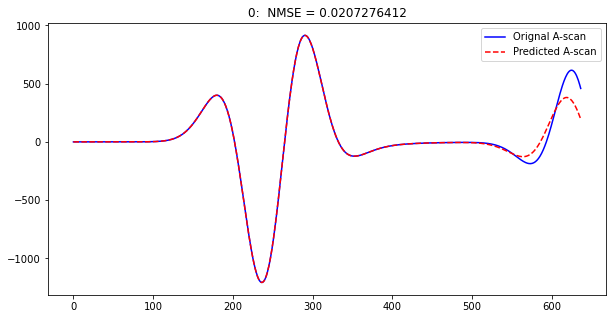

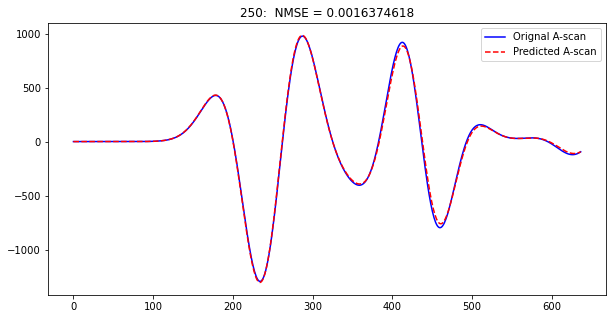

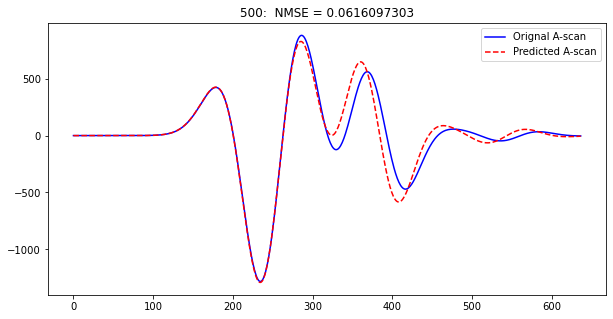

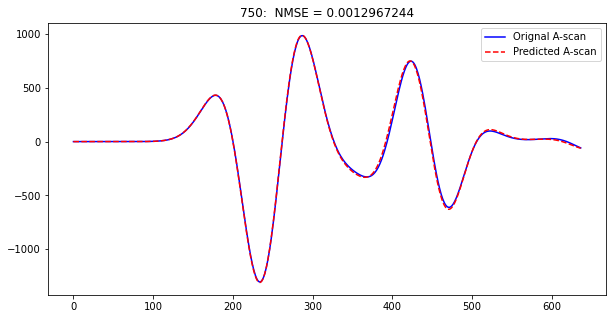

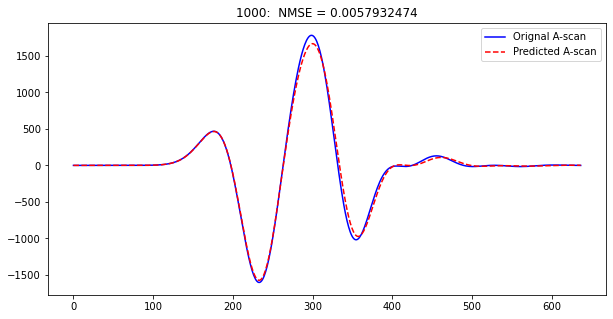

In [10]:
plot_pred_dat(test_y, y_pred_final, [], nmse)

## Chain Regression with Random Forest

A Chain Regressor is a multi-label model that arranges regressions into a chain. Each model makes a prediction in the order specified by the chain using all of the available features provided to the model plus the predictions of models that are earlier in the chain.

We use scikit-learn's `RegressorChain` function for this purpose [(docs)](https://scikit-learn.org/stable//modules/generated/sklearn.multioutput.RegressorChain.html)

In [11]:
from sklearn.multioutput import RegressorChain
rf_ChainRegression = RegressorChain(rf_regr).fit(train_x,train_y)

Batch Error = 0.08095668546877136


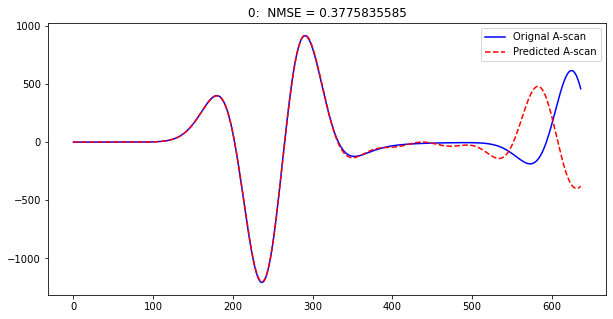

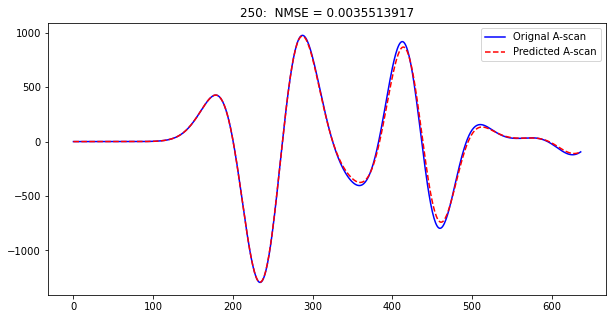

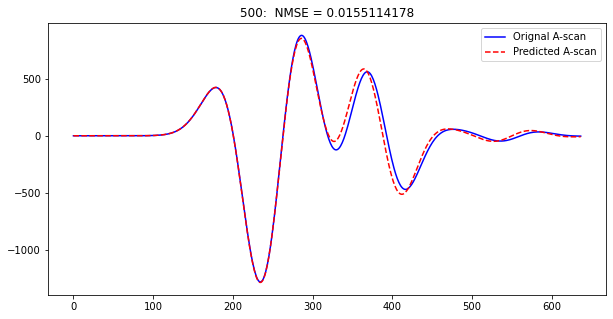

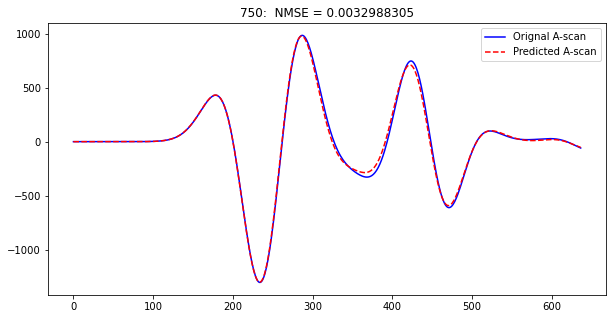

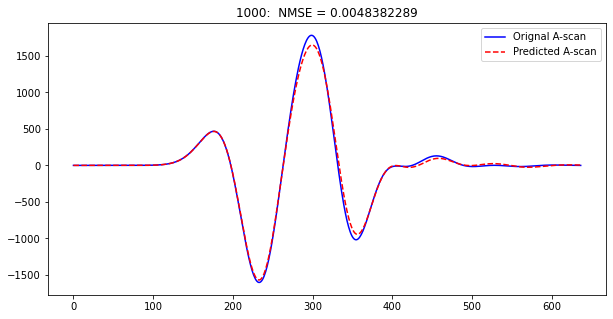

In [12]:
y_pred_compr = rf_ChainRegression.predict(test_x)
y_pred_final = pca.inverse_transform(y_pred_compr)

plot_pred_dat(test_y, y_pred_final, [], nmse)

# XGBoost

XGBoost only supports single output regression natively. For multi-output regression, we need to use scikit-learn's `MultiOutputRegressor` as a wrapper of `XGBRegressor`. 

`MultiOutputRegressor` trains one regressor per target and only requires that the regressor implements `fit` and `predict`, which `xgboost` happens to support [(further description)](https://stackoverflow.com/questions/39540123/muti-output-regression-in-xgboost) 

In [13]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb

In [14]:
xg_regr = xgb.XGBRegressor(objective='reg:squarederror')
mult_xgb_regr = MultiOutputRegressor(xg_regr).fit(train_x, train_y)

/Users/utsavakhaury/opt/miniconda3/envs/gprMax/lib/python3.9/site-packages/xgboost/data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Batch Error = 0.028498628229150953


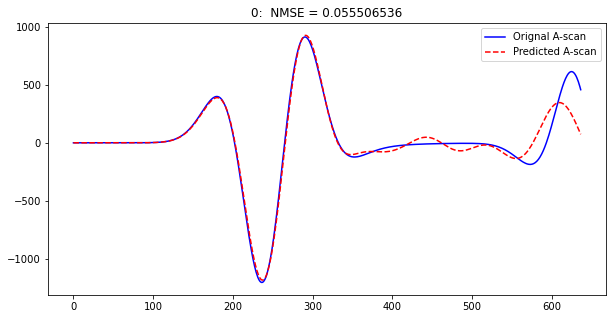

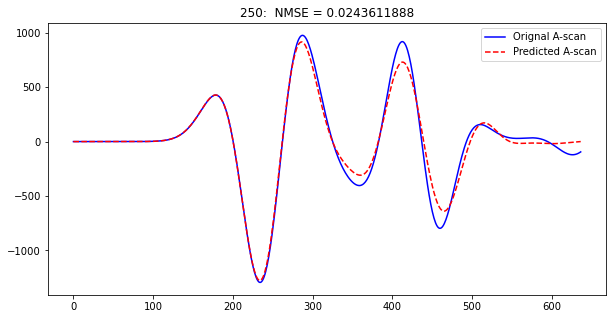

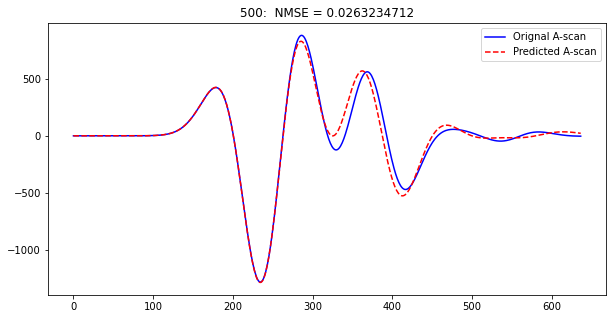

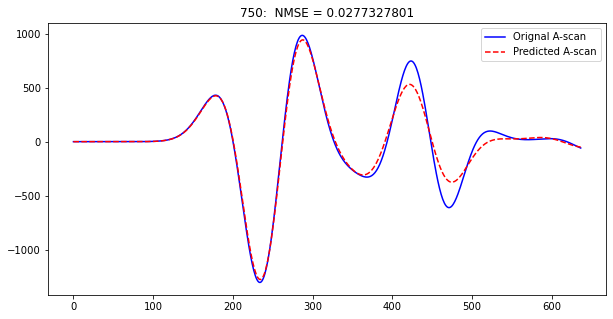

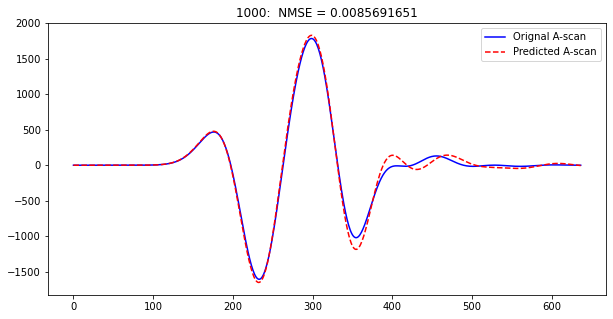

In [15]:
y_pred_compr = mult_xgb_regr.predict(test_x)
y_pred_final = pca.inverse_transform(y_pred_compr)

plot_pred_dat(test_y, y_pred_final, [], nmse)

## Chain Regression with XGBoost

In [16]:
xgb_ChainRegression = RegressorChain(xg_regr).fit(train_x,train_y)

/Users/utsavakhaury/opt/miniconda3/envs/gprMax/lib/python3.9/site-packages/xgboost/data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Batch Error = 0.1011269026511854


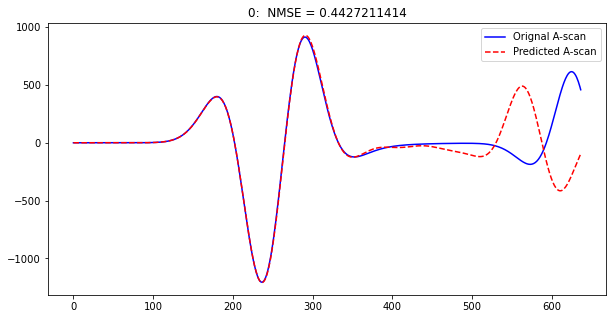

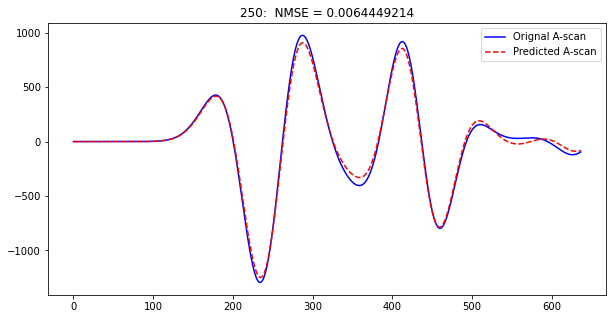

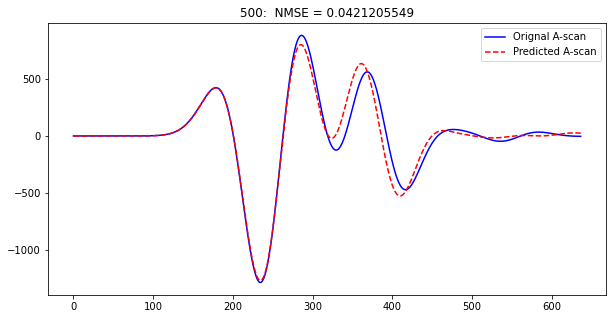

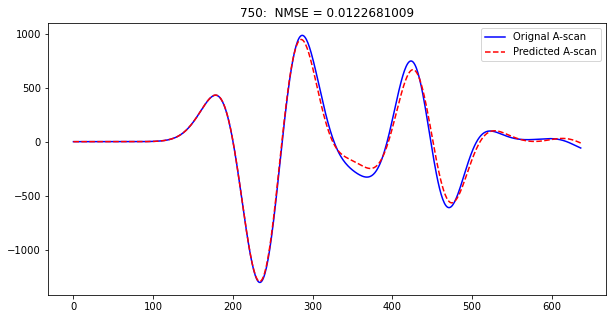

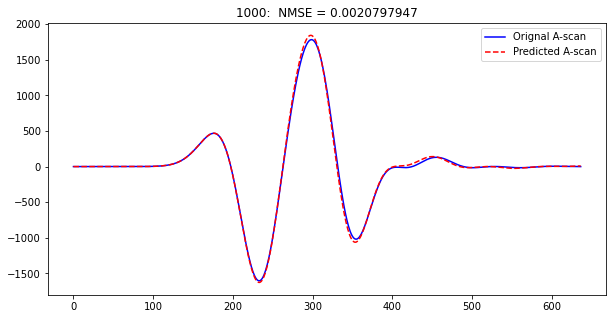

In [17]:
y_pred_compr = xgb_ChainRegression.predict(test_x)
y_pred_final = pca.inverse_transform(y_pred_compr)

plot_pred_dat(test_y, y_pred_final, [], nmse)

# SVM Regression

In [18]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [19]:
svm_regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
mult_svm_regr = MultiOutputRegressor(svm_regr).fit(train_x, train_y)

Batch Error = 0.24884502120053828


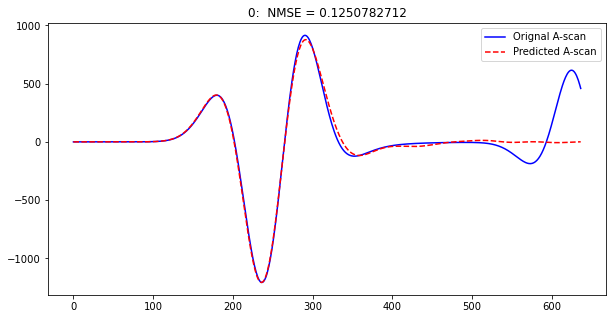

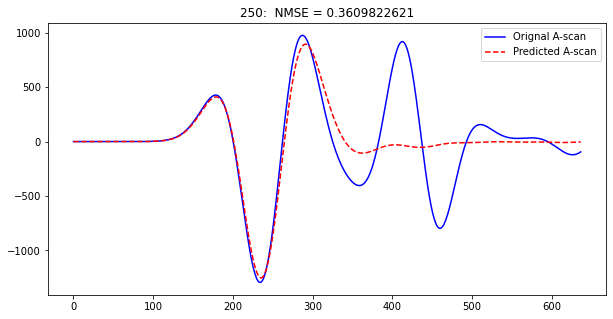

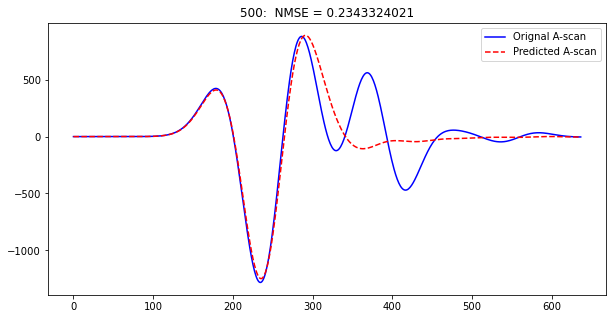

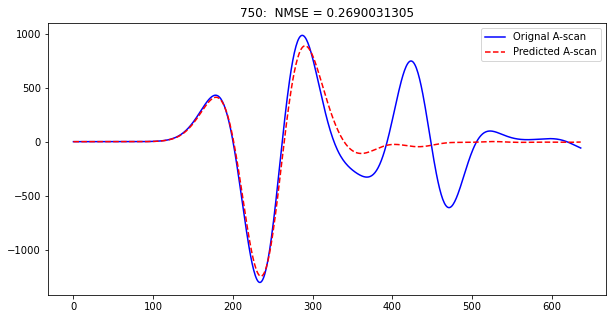

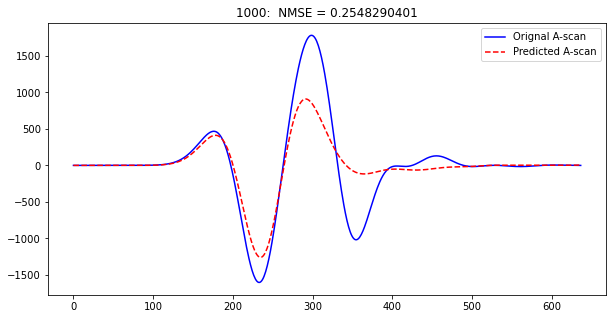

In [20]:
y_pred_compr = mult_svm_regr.predict(test_x)
y_pred_final = pca.inverse_transform(y_pred_compr)

plot_pred_dat(test_y, y_pred_final, [], nmse)

## Chain Regression with SVM

In [21]:
svm_ChainRegression = RegressorChain(svm_regr).fit(train_x,train_y)

Batch Error = 0.24879149855163973


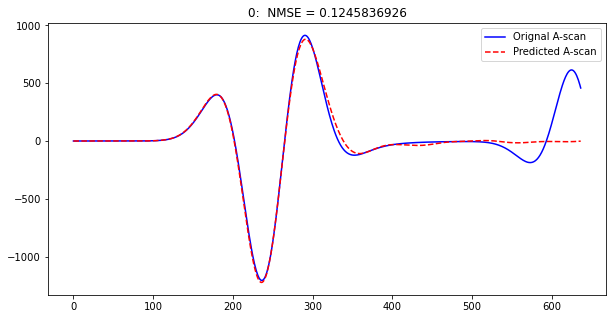

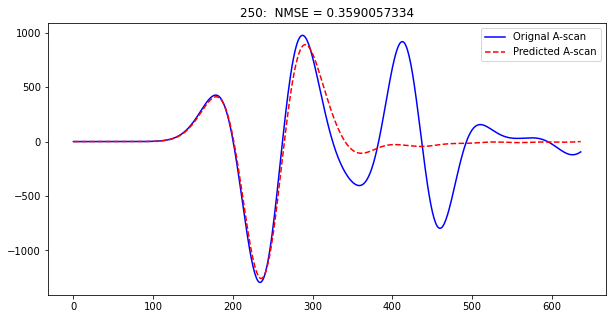

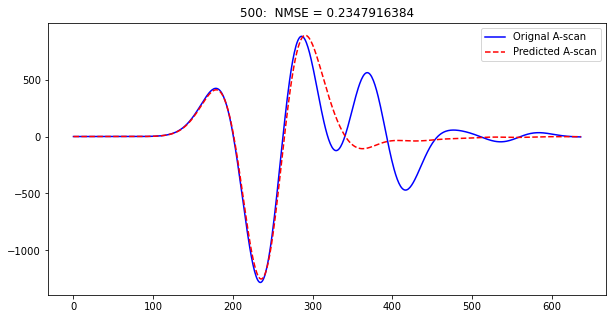

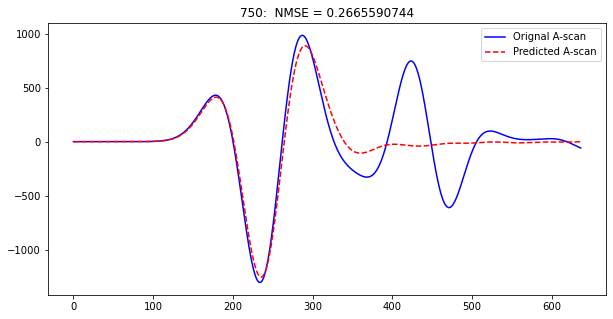

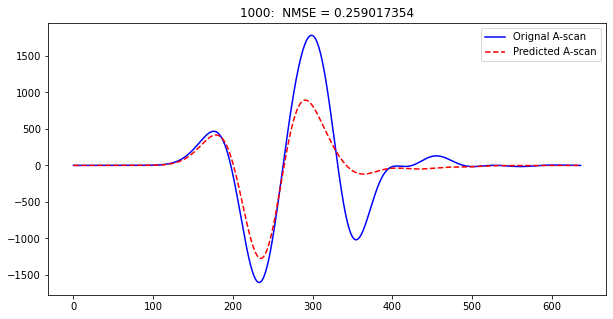

In [22]:
y_pred_compr = svm_ChainRegression.predict(test_x)
y_pred_final = pca.inverse_transform(y_pred_compr)

plot_pred_dat(test_y, y_pred_final, [], nmse)

# SGDRegressor

In [23]:
from sklearn.linear_model import SGDRegressor

In [24]:
sgd_regr = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-5))
mult_sgd_regr = MultiOutputRegressor(sgd_regr).fit(train_x, train_y)

Batch Error = 0.2394121657040012


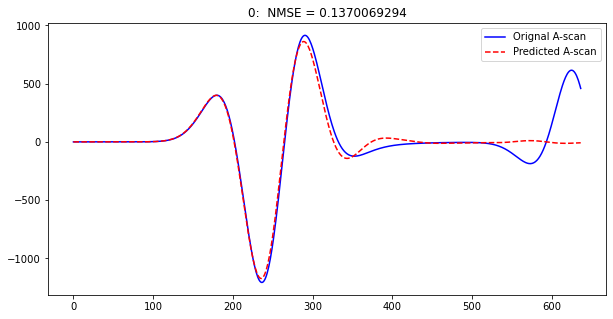

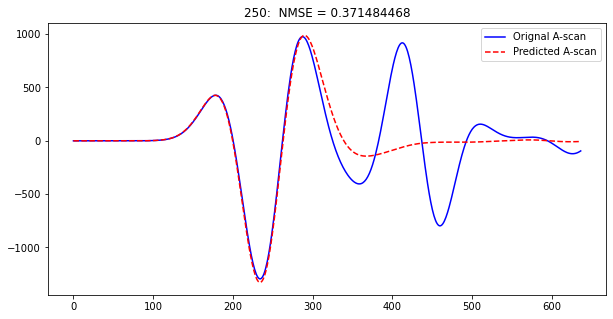

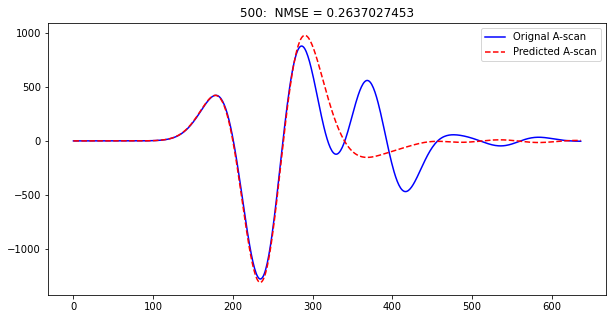

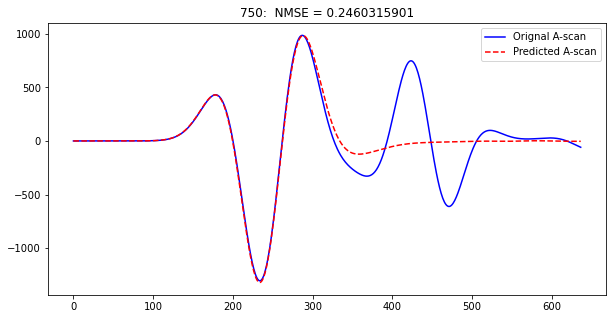

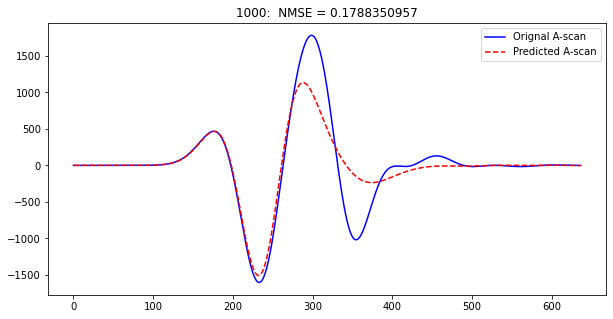

In [25]:
y_pred_compr = mult_sgd_regr.predict(test_x)
y_pred_final = pca.inverse_transform(y_pred_compr)

plot_pred_dat(test_y, y_pred_final, [], nmse)

## Chain Regression with SGDRegressor

In [26]:
sgd_ChainRegression = RegressorChain(sgd_regr).fit(train_x,train_y)

Batch Error = 0.240172865380113


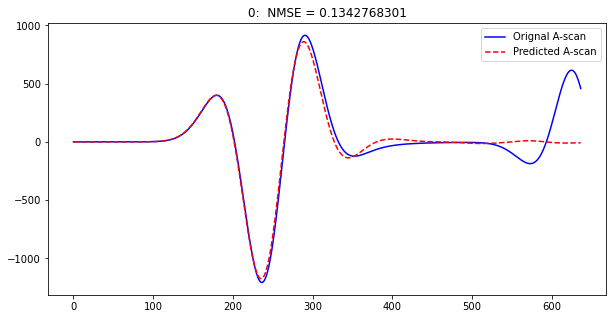

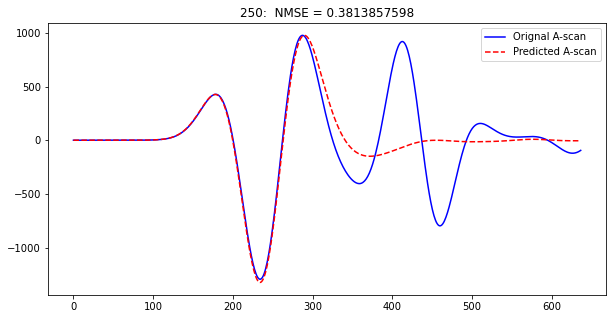

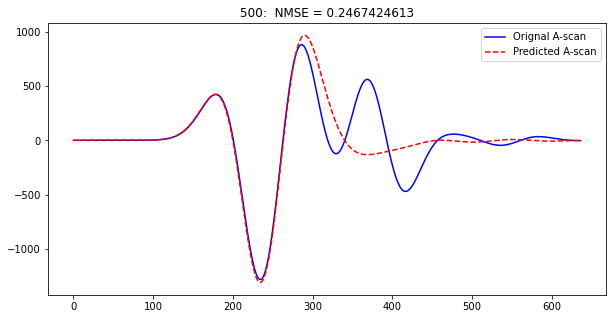

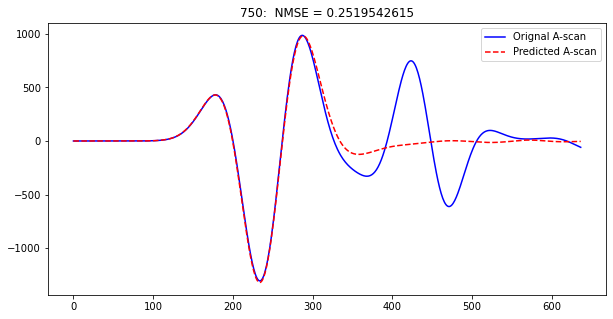

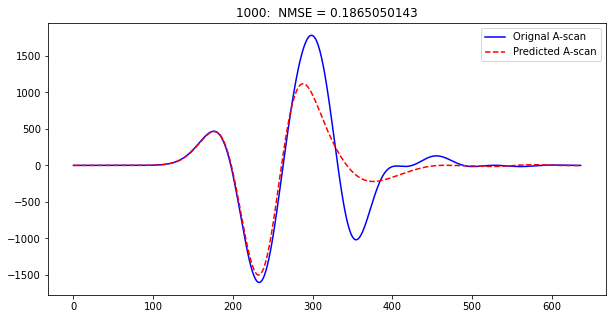

In [27]:
y_pred_compr = sgd_ChainRegression.predict(test_x)
y_pred_final = pca.inverse_transform(y_pred_compr)

plot_pred_dat(test_y, y_pred_final, [], nmse)

# Gradient Boosting Regressor (from sklearn.ensemble)

In [28]:
from sklearn.ensemble import GradientBoostingRegressor
mult_gbr_regr = MultiOutputRegressor(GradientBoostingRegressor(random_state=42)).fit(train_x, train_y)

Batch Error = 0.11907216501694765


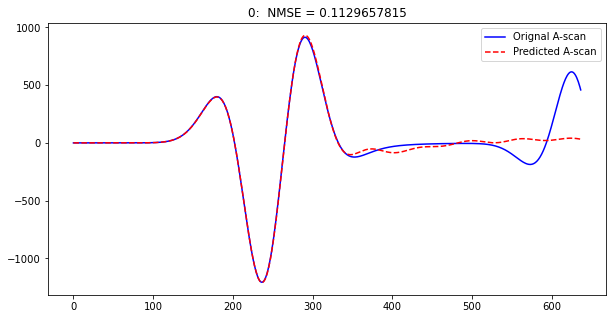

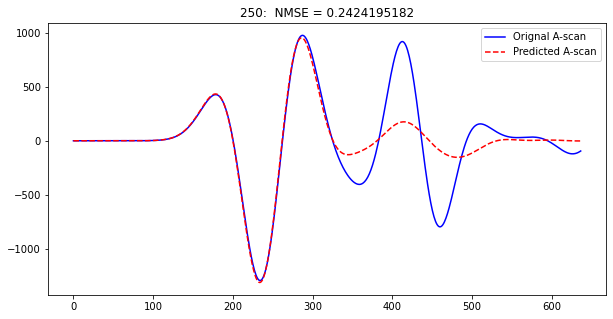

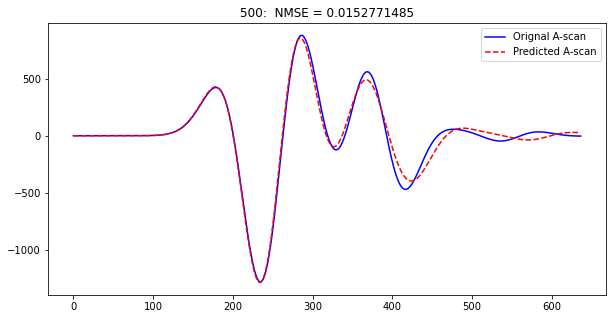

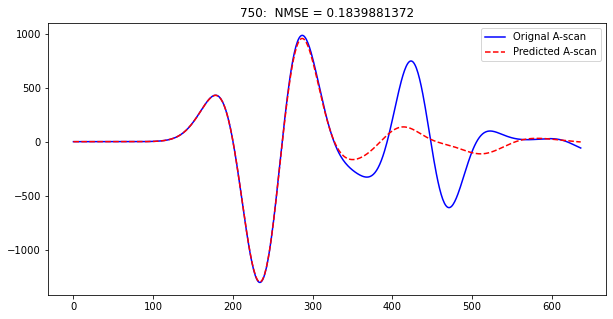

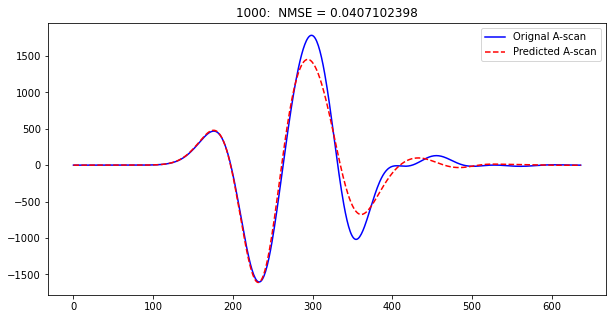

In [29]:
y_pred_compr = mult_gbr_regr.predict(test_x)
y_pred_final = pca.inverse_transform(y_pred_compr)

plot_pred_dat(test_y, y_pred_final, [], nmse)

## Chain Regression (with GradientBoostingRegressor)

In [30]:
ChainRegression = RegressorChain(GradientBoostingRegressor(random_state=42)).fit(train_x,train_y)

Batch Error = 0.13020276078667306


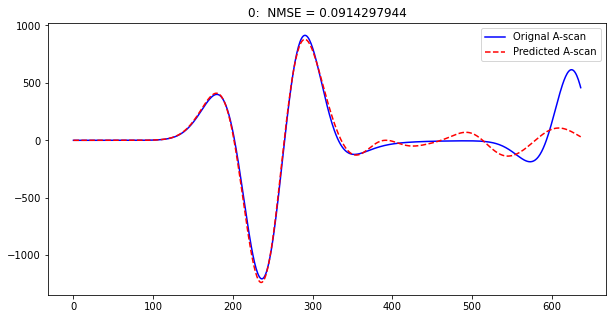

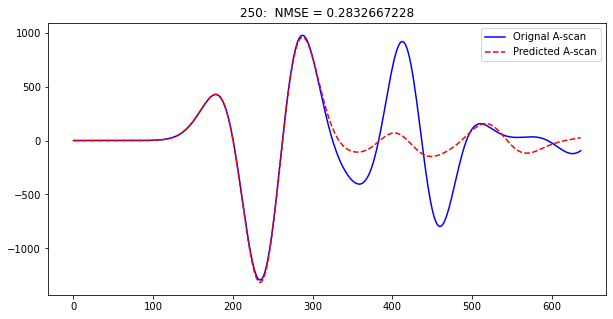

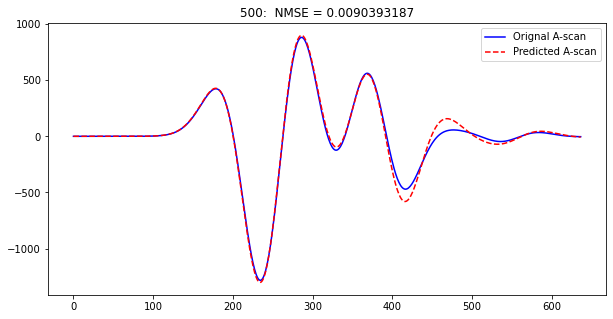

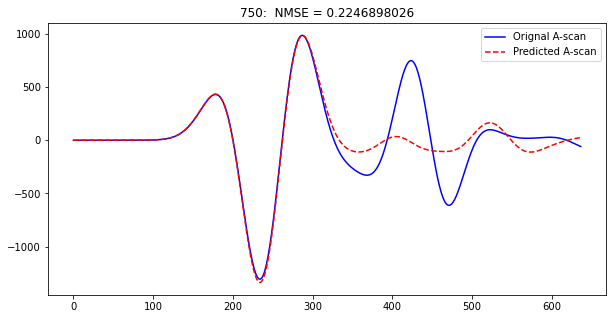

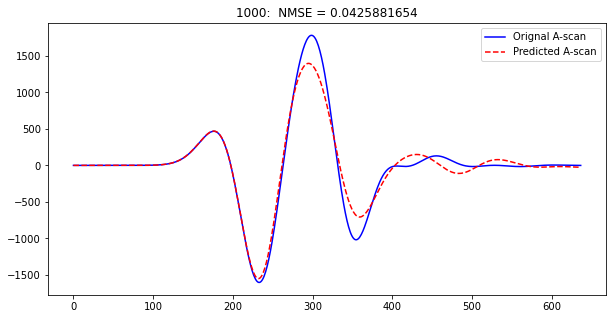

In [31]:
y_pred_compr = ChainRegression.predict(test_x)
y_pred_final = pca.inverse_transform(y_pred_compr)

plot_pred_dat(test_y, y_pred_final, [], nmse)

# Performance Comparison

| Method | NMSE (on 1250 test samples) | Training Time (s)
| --- | --- | --- |
| Random Forest | 0.0182 | 2.8
| Random Forest + Chain Regression | 0.0809 | 179.5
| XGBoost | 0.0285 | 8.8
| XGBoost + Chain Regression | 0.1011 | 17.4
| SVM | 0.2488 | 25.7
| SVM + Chain Regression | 0.2487 | 22.3
| SGDRegressor | 0.2394 | 0.1
| SGDRegressor + Chain Regression | 0.2402 | 0.4
| Gradient Boosting Regressor | 0.1191 | 17.4
| Gradient Boosting Regressor + Chain Regression | 0.1302 | 74.1
